In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import cv2, random
from pathlib import Path
import dataclasses

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import DefaultPredictor



from warnings import filterwarnings
filterwarnings("ignore")

import os
import sys
sys.path.append(os.path.join(str(os.path.abspath('')), "..", "..", "..", ".."))
# from src.detector.get_dicts import get_COVID19_data_dicts
from src.detector.custom_trainer import MyTrainer
from src.detector.flags import Flags
from src.detector.save_yaml import save_yaml


setup_logger()

<Logger detectron2 (DEBUG)>

In [2]:
import pandas as pd
from tqdm import tqdm
import cv2
import pickle
from detectron2.structures import BoxMode
from pathlib import Path
from typing import Optional
import numpy as np


def get_COVID19_data_dicts(
        root_imgdir: str,
        path_to_meta_df: str,
        path_to_train_df: str,
        use_cache: bool = True,
        debug: bool = False,
        img_size: str = '512x512',
        fold: int = 0,
        cv_scheme: str = 'skf',
        use_negative: bool = False,
        binary_task: bool = True,
        mode: str = 'train'

):
    train_df = pd.read_csv(path_to_train_df)
    cache_path = Path(".") / f"dataset_dicts_cache_{mode}_cv_scheme_{cv_scheme}_fold_{fold}_img_size_{img_size}_binary_task_{binary_task}_use_negative_{use_negative}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # df_meta = pd.read_csv("../input/siim-covid19-resized-1024px/meta.csv") !!!!!!!!!!!!!!!!!!!!!!
        df_meta = pd.read_csv(path_to_meta_df)

        if mode == 'train':
            if cv_scheme == 'skf':
                train_meta = df_meta[df_meta.skf_fold != fold]
            if cv_scheme == 'gkf':
                train_meta = df_meta[df_meta.gkf_fold != fold]
        if mode == 'val':
            if cv_scheme == 'skf':
                train_meta = df_meta[df_meta.skf_fold == fold]
            if cv_scheme == 'gkf':
                train_meta = df_meta[df_meta.gkf_fold == fold]

        if debug:
            train_meta = train_meta.iloc[:100]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.iloc[0, 5]
        # image_path = str(imgdir / "train" / f"{image_id}.jpg")
        image_path = root_imgdir + img_size + f'/train/{image_id}.jpg'
        print(image_path)
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}
            _, width, height, _, _, image_id = train_meta_row.values
            # filename = str(imgdir / "train" / f"{image_id}.jpg")
            # filename = str(f'../input/siim-covid19-resized-1024px/train/{image_id}.jpg') !!!!!!!!!!!!!!!
            image_path = root_imgdir + img_size + f'/train/{image_id}.jpg'
            filename = image_path
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = None

                if binary_task:
                    class_id = row["binary_class"]
                if not binary_task:
                    class_id = row["class"]

                if class_id == 0:  # NO class
                    # It is "No finding"
                    if use_negative:
                        # Use this No finding class with the bbox covering all image area.
                        bbox_resized = [0, 0, resized_width, resized_height]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)

                elif class_id != 0:
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        float(row["x_min"]) * w_ratio,
                        float(row["y_min"]) * h_ratio,
                        float(row["x_max"]) * w_ratio,
                        float(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": 0,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


In [3]:
flags_dict = {
    "debug": False,
    "fold": 3,
    "outdir": "results/", 
    "root_imgdir": PATH_TO_IMAGES, # !!! DEFINE "PATH_TO_IMAGES" on your local machine,
    "path_to_meta_df": "../../cross_validation_scheme/detectron_prepared_data/meta_df.csv",
    "path_to_train_df": "../../cross_validation_scheme/detectron_prepared_data/detectron_prepared_df.csv",
    "use_cache": True,
    "img_size": "1024x1024",
    "cv_scheme": "skf",
    "use_negative": False,
    "binary_task": True,
    
    "iter": 10000,
    "roi_batch_size_per_image": 256,
    "eval_period": 1000,
    "lr_scheduler_name": "WarmupMultiStepLR",
    "base_lr": 0.00025,
    "num_workers": 4,
    "ims_per_batch": 4,
    
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
#         "HueSaturationValue": {"hue_shift_limit": 10, "sat_shift_limit": 10, "val_shift_limit": 10, "p": 0.7},
        "RandomBrightnessContrast": {"p": 0.5},
#         "CLAHE": {"clip_limit": (1,4), "p": 0.5},
#         "GaussianBlur": {"p": 0.2}
    },
}

In [4]:
flags = Flags().update(flags_dict)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(outdir / "flags.yaml", flags_dict)

In [5]:
thing_classes = [
#     "negative",
    "opacity"
]

In [6]:
DatasetCatalog.register(
    "COVID19_data_train",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='train',
                                    fold=flags.fold,
                                  ),
)
MetadataCatalog.get("COVID19_data_train").set(thing_classes=thing_classes)


DatasetCatalog.register(
    "COVID19_data_valid",
    lambda: get_COVID19_data_dicts(
                                    root_imgdir=flags.root_imgdir,
                                    path_to_meta_df=flags.path_to_meta_df,
                                    path_to_train_df=flags.path_to_train_df,
                                    use_cache=flags.use_cache,
                                    debug=flags.debug,
                                    img_size=flags.img_size,
                                    cv_scheme=flags.cv_scheme,
                                    use_negative=flags.use_negative,
                                    binary_task=flags.binary_task,
                                    mode='val',
                                    fold=flags.fold,
                                  ),
    )
MetadataCatalog.get("COVID19_data_valid").set(thing_classes=thing_classes)

dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")

dataset_dicts_valid = DatasetCatalog.get("COVID19_data_valid")
metadata_dicts_valid = MetadataCatalog.get("COVID19_data_valid")

Load from cache dataset_dicts_cache_train_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl


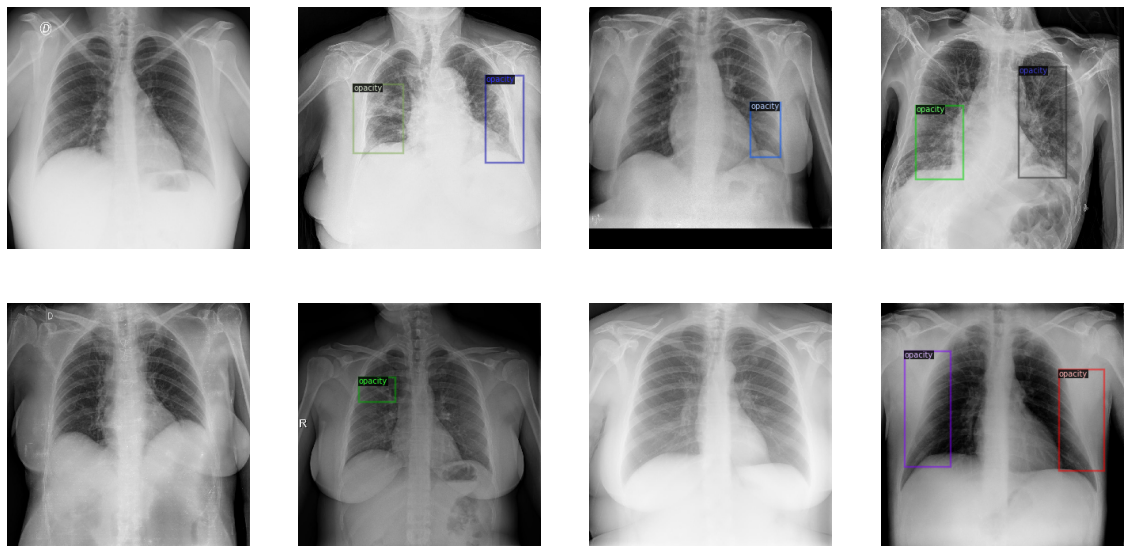

In [7]:
fig, ax = plt.subplots(2, 4, figsize =(20,10))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3]]
i=-1
for d in random.sample(dataset_dicts_train, 8):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts_train, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])

In [8]:
from detectron2.config.config import CfgNode as CN

cfg = get_cfg()
original_output_dir = cfg.OUTPUT_DIR
cfg.OUTPUT_DIR = str(outdir)
print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)
cfg.MODEL.WEIGHTS = str("results/F3_RetinaNet_4000_jpg.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01
predictor = DefaultPredictor(cfg)
cfg.DATASETS.TEST = ("COVID19_data_valid",)

Loading config /home/greylord/siim_covid/covid_env/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


cfg.OUTPUT_DIR ./output -> results


In [9]:
# trainer = MyTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# trainer.train()

In [10]:
evaluator = COCOEvaluator("COVID19_data_valid", cfg, False, output_dir="./results")
val_loader = build_detection_test_loader(cfg, "COVID19_data_valid")
inference_on_dataset(predictor.model, val_loader, evaluator)

WARNING [01/21 14:45:50 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/21 14:45:50 d2.evaluation.coco_evaluation]: 'COVID19_data_valid' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[01/21 14:45:50 d2.data.datasets.coco]: Converting annotations of dataset 'COVID19_data_valid' to COCO format ...)
Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[01/21 14:45:50 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/21 14:45:50 d2.data.datasets.coco]: Conversion finished, #images: 1212, #annotations: 1584
[01/21 14:45:50 d2.data.datasets.coco]: Caching COCO format annotations at './results/COVID19_data_valid_coco_format.json' ...
Load from cache dataset_dicts_cache_val_cv_scheme_skf_fold_3_img_size_1024x1024_binary_task_True_use_negative_False.pkl
[01/

OrderedDict([('bbox',
              {'AP': 15.557450806387763,
               'AP50': 49.326235834877195,
               'AP75': 4.145742244033747,
               'APs': nan,
               'APm': 0.9308968331205685,
               'APl': 15.769680532091845})])

In [11]:
metrics_df = pd.read_json("results/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf

,data_time,eta_seconds,iteration,loss_box_reg,loss_cls,lr,num_pos_anchors,time,total_loss,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,validation_loss
0,0.013933,4123.285986,19,0.871389,1.375949,4.299629e-05,53.2500,1.036002,2.262295,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.013686,4114.585298,39,0.560917,0.570944,8.562396e-05,48.6875,1.040902,1.134942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.014587,4099.105027,59,0.550289,0.458068,1.282516e-04,50.5000,1.043266,1.024620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.013782,4083.076024,79,0.507620,0.425872,1.708793e-04,51.6875,1.043544,0.924740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.013865,4063.884369,99,0.520153,0.437980,2.135070e-04,54.6250,1.043446,0.953312,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.017041,63.069879,3939,0.406768,0.262250,1.434288e-06,51.9375,1.052874,0.678689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,0.016939,42.051074,3959,0.382064,0.242505,6.480223e-07,54.9375,1.052525,0.619358,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,0.016696,21.026150,3979,0.393316,0.279388,1.700155e-07,52.1875,1.053564,0.663036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,0.016491,0.000000,3999,0.385836,0.252470,3.855314e-10,34.0000,1.114461,0.636652,16.732614,51.518386,4.581058,16.949149,1.690397,NaN,0.749649


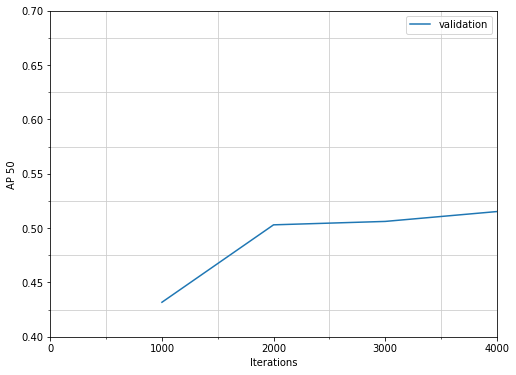

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.4, 0.7)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("AP 50")

mdf3 = mdf[~mdf["bbox/AP50"].isna()]
plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/AP50_other.png")

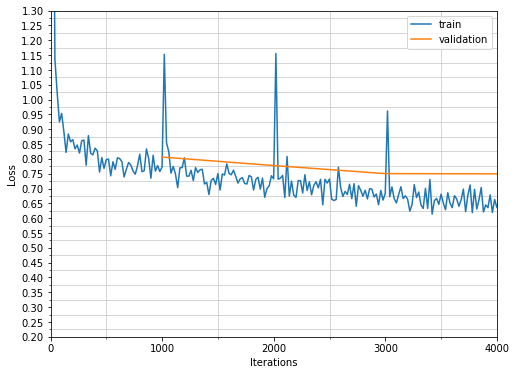

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(8, 6))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(0, 4000)
ax.set_ylim(0.2, 1.3)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

# Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC')
ax.grid(which='minor', color='#CCCCCC')


# plt.title("UnEfficientNet-B4 Training")
plt.xlabel("Iterations")
plt.ylabel("Loss")

# plt.plot(mdf3["iteration"], mdf3["bbox/AP50"] / 100., label='validation')

mdf1 = mdf[~mdf["total_loss"].isna()]
plt.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    plt.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")
plt.grid()
plt.legend()
plt.show() 
fig.savefig("results/loss_other.png")